In [21]:
#icecube:
from icecube import dataio, dataclasses, simclasses
from icecube.icetray import OMKey
from icecube.dataclasses import *

# The usual:
import os
import numpy as np
import copy

#Plotting:
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt

## Checking the data from the first simulation test runs

In [22]:
#Using new GCD:
geometry = dataio.I3File("/home/fhenningsen/gcd/physics_volume_GCD.i3.bz2")

gframe = geometry.pop_frame()  
geo = gframe["I3Geometry"] #access geo file via key
all_dom_keys = geo.omgeo.keys()

#ceate a general event dictionary with 2D array (charge,time) as values
event = {} 
all_dom_keys = geo.omgeo.keys()
for i in all_dom_keys:
    event[i] = [0,[]]

In [23]:
for i in all_dom_keys:
    a = geo.omgeo[i]
    b = str(a.omtype)
    st = i.string
    do = i.om
    knew = OMKey(st, do-1, 0)
    if 'POCAM' in b:
        print(i, st, do, b)
        print(geo.omgeo[knew].omtype)

(OMKey(87,4,0), 87, 4, 'POCAM')
DEgg
(OMKey(87,84,0), 87, 84, 'POCAM')
mDOM
(OMKey(88,2,0), 88, 2, 'POCAM')
mDOM
(OMKey(88,72,0), 88, 72, 'POCAM')
mDOM
(OMKey(89,2,0), 89, 2, 'POCAM')
mDOM
(OMKey(89,10,0), 89, 10, 'POCAM')
DEgg
(OMKey(89,13,0), 89, 13, 'POCAM')
mDOM
(OMKey(89,38,0), 89, 38, 'POCAM')
mDOM
(OMKey(89,107,0), 89, 107, 'POCAM')
mDOM
(OMKey(90,12,0), 90, 12, 'POCAM')
DEgg
(OMKey(90,14,0), 90, 14, 'POCAM')
DEgg
(OMKey(90,100,0), 90, 100, 'POCAM')
mDOM
(OMKey(91,15,0), 91, 15, 'POCAM')
mDOM
(OMKey(91,50,0), 91, 50, 'POCAM')
mDOM
(OMKey(92,6,0), 92, 6, 'POCAM')
PDOM
(OMKey(92,18,0), 92, 18, 'POCAM')
RadioReciever
(OMKey(92,28,0), 92, 28, 'POCAM')
mDOM
(OMKey(93,8,0), 93, 8, 'POCAM')
DEgg
(OMKey(93,17,0), 93, 17, 'POCAM')
WOM
(OMKey(93,64,0), 93, 64, 'POCAM')
mDOM
(OMKey(93,113,0), 93, 113, 'POCAM')
mDOM


In [24]:
def get_event_data(pocam):
    #As a first step we create a new empty data dictioniary:
    data_dict=copy.deepcopy(event)

    #Then we read in the i3 file:
    fp = '/data/user/fhenningsen/deepcore_data/sim_5d-nn-n-0-1500_2020-12-01_03-44-45/ABS-1.00222_SCA-0.87593_DOME-1.16567_P0-0.37582_P1--0.07149_NPH-1.000e+08_N-100_POCAM-%s.i3' %(pocam)
    data_tmp_i3 = dataio.I3File(os.path.expanduser(fp)) #"/home/fschmuckermaier/data/ppc_test/108_test_pocam_89_38.i3"))
    n=5
    for i in range(n): #iterate over framess
        data_tmp_fr = data_tmp_i3.pop_daq() #pop frame
        data_tmp_k = data_tmp_fr['MCPESeriesMap'] #data is stored in 'MCPESeriesMap'
        for c,j in enumerate(data_tmp_k.iteritems()): 

            dom_key= j[0]
            charge = len(j[1])
            data_dict[dom_key][0] += charge #adding up hits
            data_dict[dom_key][1] += [j.time for j in j[1]] #appending list of time stamps

    for i in all_dom_keys:  #go through all DOMs
        ### Averaging to charge per run ###
        data_dict[i][0] = data_dict[i][0]/float(n)


        if len(data_dict[i][1]) != 0: #look only at hit DOMs
            bins = np.linspace(0,10000,1001) #bin array in 10ns
            array,edges=np.histogram(data_dict[i][1],bins=bins) #bin hits in 10ns
            if (max(array)/float(n)) < 312:  #curent limit of 50mA (or 312 p.e. per 10ns)

                ### Averaging time array to mean arrival time ###
                data_dict[i][1] = np.mean(data_dict[i][1]) 

            else: #remove saturated DOMs:
                data_dict[i][0] = 0
                data_dict[i][1] = [0]
        else: #set mean arrival time to 0 for non hit DOMs
            data_dict[i][1] = [0]
            
    return data_dict

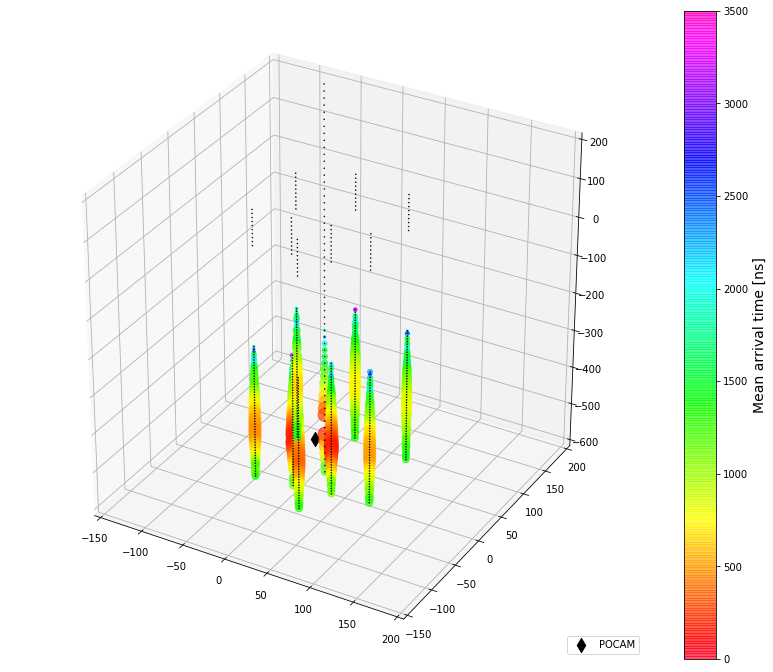

In [25]:
### Then plot ###
pocam_key=OMKey(88,72,0)
pocam    = '%s-%s' %(pocam_key.string, pocam_key.om)
data_dict = get_event_data(pocam)

fig = plt.figure(figsize=(11,9))
ax = Axes3D(fig)

#DOM arrays for plotting DOMs as black dots
x_doms_d=[]
y_doms_d=[]
z_doms_d=[]
#DOM arrays for plotting hit DOMs 
x_doms=[]
y_doms=[]
z_doms=[]
times=[]
sizes=[]

for i in all_dom_keys:
    d=np.sqrt((geo.omgeo[i].position.x-geo.omgeo[pocam_key].position.x)**2 + (geo.omgeo[i].position.y-geo.omgeo[pocam_key].position.y)**2 + (geo.omgeo[i].position.z-geo.omgeo[pocam_key].position.z)**2 )  
    
    if geo.omgeo[i].position.z < 500 and i.string < 87: #Ignore IceTop and upgrade
        x_doms_d.append(geo.omgeo[i].position.x)
        y_doms_d.append(geo.omgeo[i].position.y)
        z_doms_d.append(geo.omgeo[i].position.z)

    if data_dict[i][0] != 0 and i.string < 87 and d<1000: #only look at hit DOMs and ignore upgrade modules (+distance limit)
        x_doms.append(geo.omgeo[i].position.x)
        y_doms.append(geo.omgeo[i].position.y)
        z_doms.append(geo.omgeo[i].position.z)
        times.append(data_dict[i][1]) #time as color
        sizes.append(30*np.log(data_dict[i][0]+1)) #counts as size (scaling is arbitrary in this case)

#Detector:
p=ax.scatter(x_doms_d,y_doms_d,z_doms_d,c='k',s=0.3,alpha=1)

#Hits:
p=ax.scatter(x_doms,y_doms,z_doms,c=times,cmap='gist_rainbow', vmin=0, vmax=3500,s=sizes,alpha=0.7)
cbar=fig.colorbar(p)
cbar.set_label("Mean arrival time [ns]",fontsize=14)

#POCAM:
p=ax.scatter(geo.omgeo[pocam_key].position.x,geo.omgeo[pocam_key].position.y,geo.omgeo[pocam_key].position.z,s=100,c='k',marker="d",label='POCAM')

ax.set_xlim(-150,200)
ax.set_ylim(-150,200)
ax.set_zlim(-600,200)
ax.legend(loc="lower right")
plt.show()

In [26]:
def plot_all_pocams():
    
    for pocam_key in [OMKey(87,84,0), OMKey(88,72,0), OMKey(89,38,0), OMKey(90,100,0),
                      OMKey(91,50,0), OMKey(92,28,0), OMKey(93,64,0)]:
        
        ### Then plot ###
        pocam    = '%s-%s' %(pocam_key.string, pocam_key.om)
        data_dict = get_event_data(pocam)
        
        fig = plt.figure(figsize=(11,9))
        ax = Axes3D(fig)

        #DOM arrays for plotting DOMs as black dots
        x_doms_d=[]
        y_doms_d=[]
        z_doms_d=[]
        #DOM arrays for plotting hit DOMs 
        x_doms=[]
        y_doms=[]
        z_doms=[]
        times=[]
        sizes=[]

        for i in all_dom_keys:
            d=np.sqrt((geo.omgeo[i].position.x-geo.omgeo[pocam_key].position.x)**2 + (geo.omgeo[i].position.y-geo.omgeo[pocam_key].position.y)**2 + (geo.omgeo[i].position.z-geo.omgeo[pocam_key].position.z)**2 )  

            if geo.omgeo[i].position.z < 500 and i.string < 87: #Ignore IceTop and upgrade
                x_doms_d.append(geo.omgeo[i].position.x)
                y_doms_d.append(geo.omgeo[i].position.y)
                z_doms_d.append(geo.omgeo[i].position.z)

            if data_dict[i][0] != 0 and i.string < 87 and d<1000: #only look at hit DOMs and ignore upgrade modules (+distance limit)
                x_doms.append(geo.omgeo[i].position.x)
                y_doms.append(geo.omgeo[i].position.y)
                z_doms.append(geo.omgeo[i].position.z)
                times.append(data_dict[i][1]) #time as color
                sizes.append(30*np.log(data_dict[i][0]+1)) #counts as size (scaling is arbitrary in this case)

        #Detector:
        p=ax.scatter(x_doms_d,y_doms_d,z_doms_d,c='k',s=0.3,alpha=1)

        #Hits:
        p=ax.scatter(x_doms,y_doms,z_doms,c=times,cmap='gist_rainbow', vmin=0, vmax=3500,s=sizes,alpha=0.7)
        cbar=fig.colorbar(p)
        cbar.set_label("Mean arrival time [ns]",fontsize=14)

        #POCAM:
        p=ax.scatter(geo.omgeo[pocam_key].position.x,geo.omgeo[pocam_key].position.y,geo.omgeo[pocam_key].position.z,s=100,c='k',marker="d",label='POCAM')

        ax.set_xlim(-150,200)
        ax.set_ylim(-150,200)
        ax.set_zlim(-600,200)
        ax.legend(loc="lower right")
        plt.savefig('eventview_pocam-%s.pdf' %pocam)
        plt.show()

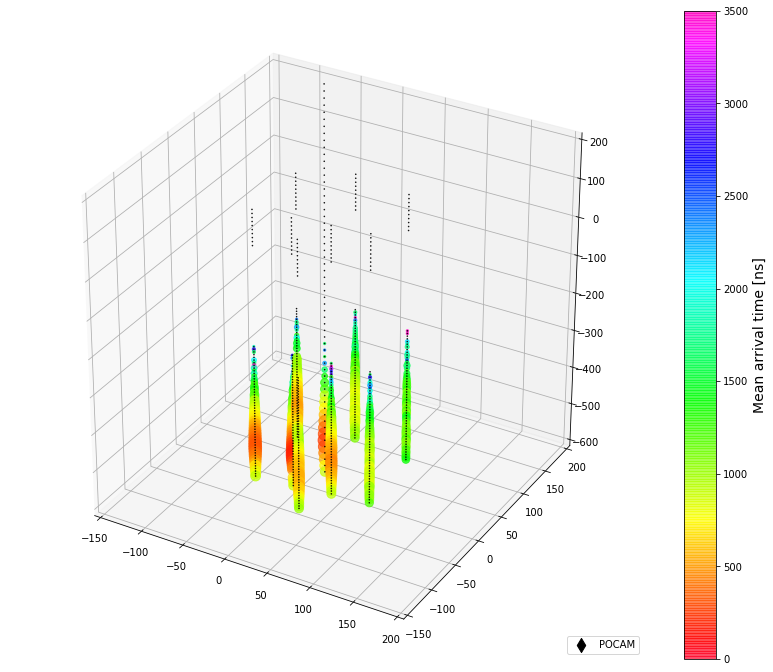

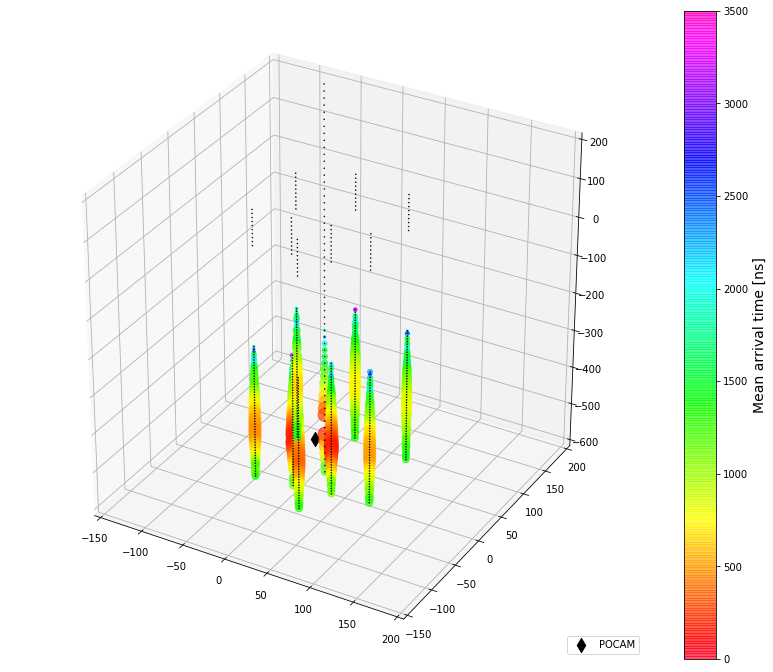

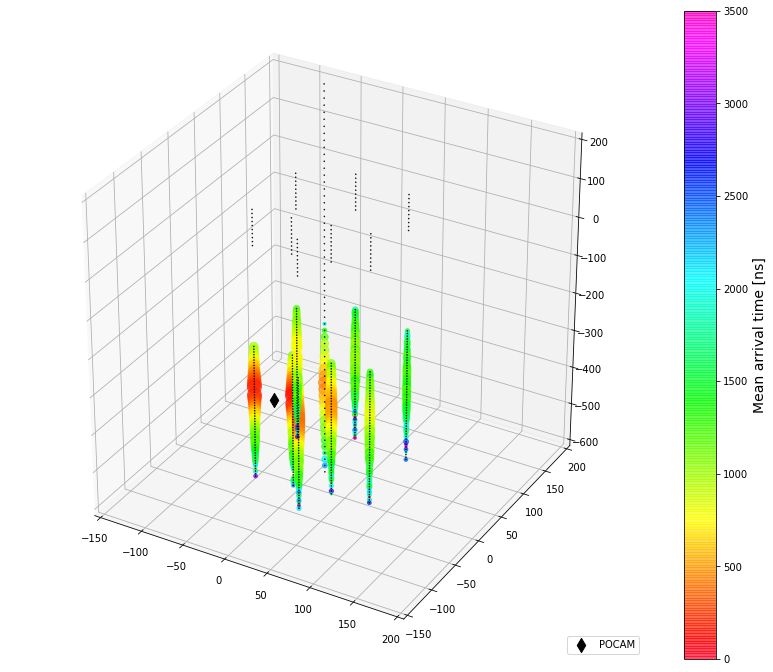

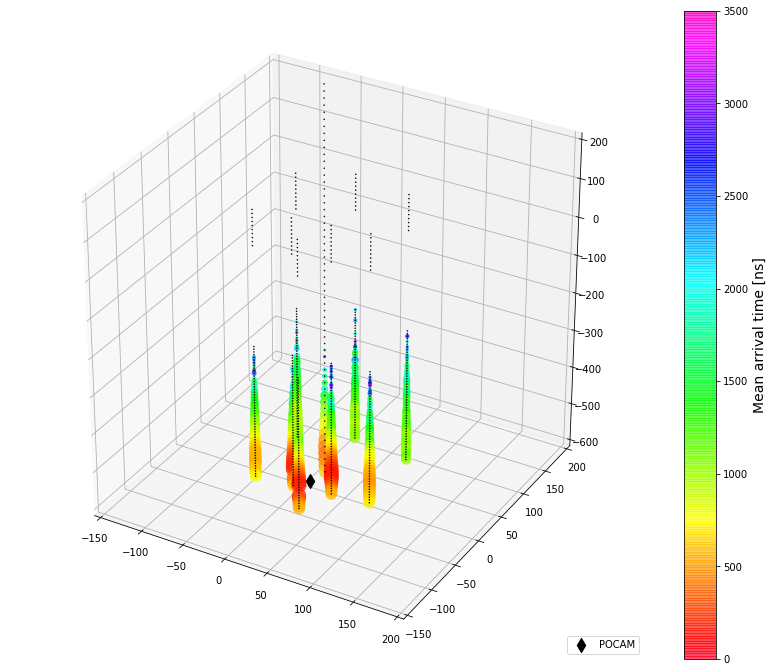

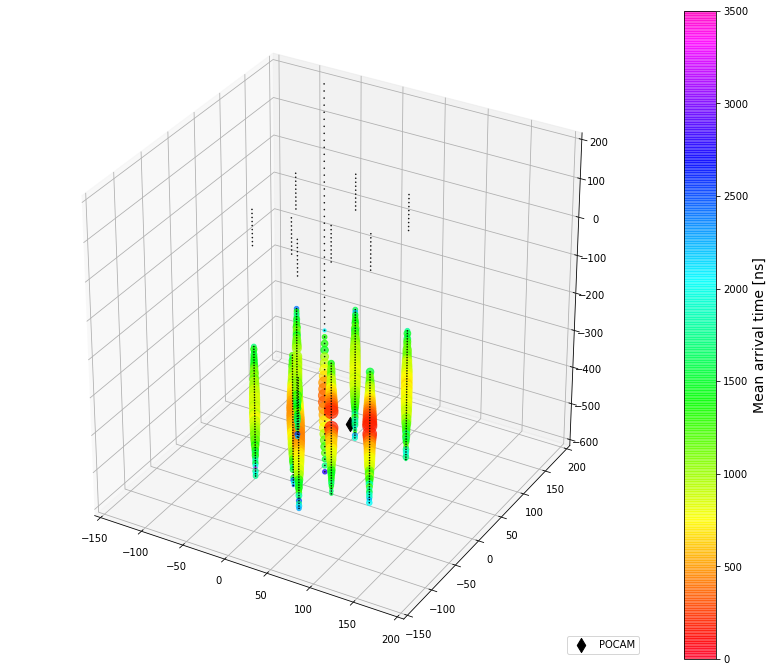

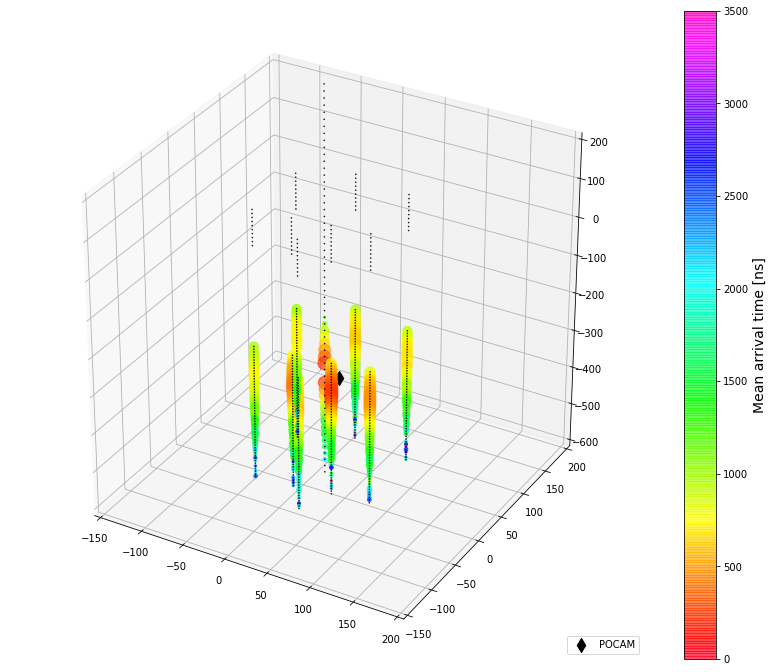

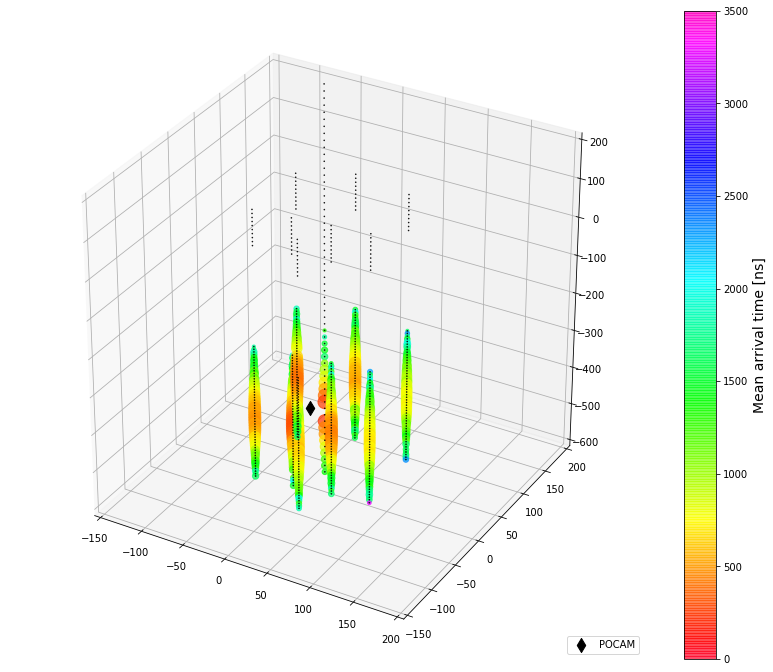

In [27]:
plot_all_pocams()